In [1]:
from Levenshtein import distance
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from arithmetic_lm.model import load_model
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.constants import PLOTS_DIR, CHECKPOINTS_DIR
from arithmetic_lm.utils import get_carry_str

import warnings

warnings.filterwarnings("ignore")

In [2]:
tokenizer = CharTokenizer()
stop_token = tokenizer.encode("$")[0]

In [3]:
# load model
model_name = "trans_dec_6layers_768embd_4head_randsp0.5_rev_ansloss"
ckpt_path = "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_randsp0.5_rev_ansloss/step1000000-train_loss0.0002-val_loss0.0000.ckpt"
model, hparams = load_model(ckpt_path)
model.to("mps")
model.eval()

TransformerDecoder(
  (embedding): Embedding(100, 768)
  (pos_encoder): AbsolutePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=100, bias=False)

In [4]:
print(hparams["extra_hparams"]["data_format"])
reverse_ops = hparams["extra_hparams"]["data_format"]["reverse_ops"]
reverse_ans = hparams["extra_hparams"]["data_format"]["reverse_ans"]

{'pad': '$', 'pad_ops_zero': None, 'pad_ans_zero': None, 'reverse_ops': True, 'reverse_ans': True, 'encdec': False, 'filler_tokens_prompt': 0, 'filler_tokens_ans': 0, 'operand_random_spaces_amount': 0.5, 'chain_of_thought': False}


In [5]:
def get_layer_logits(model, prompt: torch.Tensor) -> list[torch.Tensor]:
    """
    get the last token logits from each layer (LogitLens)
    """

    model.eval()

    layer_logits = {}

    def hook_wrapper(layer: int):
        def hook(module, input, output):
            layer_logits[layer] = output

        return hook

    hook_handles = []
    for layer in range(model.n_layers):
        hook_handles.append(
            model.transformer_encoder.layers[layer].register_forward_hook(
                hook_wrapper(layer)
            )
        )

    # forward pass
    with torch.no_grad():
        model(prompt)

    # remove hooks
    for handle in hook_handles:
        handle.remove()

    # apply lm_head to last token logits for each layer
    with torch.no_grad():
        for layer in range(model.n_layers):
            layer_logits[layer] = model.lm_head(layer_logits[layer][:, -1]).squeeze()

    return layer_logits

In [37]:
def logit_lens(
    model,
    model_name,
    tokenizer,
    prompt_idx: torch.Tensor,
    true_ans: str,
    max_new_tokens: int,
    carry_str: str = None,
    stop_token: str = "$",
):
    """
    Plot unembedded logits from layers
    """

    # shape: (seq_len, n_layers)
    logits = []
    # string, shape (seq_len, n_layers)
    tokens = []

    prompt = prompt_idx.clone()
    pred_str = ""

    for _ in range(max_new_tokens):
        # get logits
        logits_per_layer = get_layer_logits(model, prompt.unsqueeze(0))

        # get top tokens and their logits
        logits_step = []
        tokens_step = []
        for layer in range(model.n_layers):
            top_token_idx = logits_per_layer[layer].argmax().item()
            top_token: str = tokenizer.decode([top_token_idx])
            top_logit: float = logits_per_layer[layer].max().item()
            logits_step.append(top_logit)
            tokens_step.append(top_token)
        logits.append(logits_step)
        tokens.append(tokens_step)

        pred_str += top_token

        if top_token == stop_token:
            break

        # add top token from last layer to prompt
        # top token is the last top_token_idx left from the loop (i know bad practice)
        prompt = torch.cat([prompt, torch.tensor([top_token_idx]).to(prompt.device)])

    # transpose for plotting
    logits = pd.DataFrame(logits).T
    tokens = pd.DataFrame(tokens).T

    prompt_str = tokenizer.decode(prompt_idx.tolist())

    pred_dist = distance(pred_str, true_ans)
    pred_correct = [a == b for a, b in zip(pred_str, true_ans)]

    # plot small carry row on top, and heatmap of logits and add tokens to cells
    # x axis is sequence position, y axis is layer
    # on x axis add final predicted tokens
    scale = 1.5
    fig, ax = plt.subplots(
        figsize=(len(pred_str) / scale, model.n_layers / scale),
    )

    # plot main heatmap
    sns.heatmap(logits, ax=ax, annot=tokens, fmt="", cmap="viridis")
    ax.set_xlabel("Sequence ('c' means a carry was generated)")
    ax.set_ylabel("Layer")
    ax.set_title(
        f"LogitLens for {model_name}\nPrompt: {prompt_str}\nPrediction: {pred_str} (distance: {pred_dist})\nTrue: {true_ans}"
    )

    # set xticklabels to predicted tokens
    ax.set_xticks(np.arange(len(pred_str)) + 0.5)
    xlabels = [f"{a}{'\nc' if c in ('c', 'C') else "\n"}" for a, c in zip(pred_str, carry_str)]
    for i, correct in enumerate(pred_correct):
        if not correct:
            xlabels[i] += f"\n{true_ans[i]}"
    if len(xlabels) < len(pred_str):
        xlabels += pred_str[len(xlabels):]
    ax.set_xticklabels(xlabels)

    # set color of x axis labels to red & add correct pred if it's wrong
    for i, correct in enumerate(pred_correct):
        if not correct:
            ax.get_xticklabels()[i].set_color("red")
            ax.get_xticklabels()[i].set_weight("bold")

    # put boxes around actually predicted token in each column
    tokens_predicted = tokens.apply(lambda x: x == x.iloc[-1], axis=0)
    for i, predicted in enumerate(tokens_predicted.values):
        for j, is_predicted in enumerate(predicted):
            is_true = tokens.iloc[i, j] == true_ans[j]
            if is_predicted or is_true:
                color = {True: "black", False: "red"}[(is_predicted and is_true) or is_true]
                ax.add_patch(
                    plt.Rectangle(
                        (j, i),
                        1,
                        1,
                        fill=False,
                        edgecolor=color,
                        clip_on=False,
                        lw=3,
                    )
                )

    plt.tight_layout()

    # save plot
    plot_path = PLOTS_DIR / "gen_to_longer_rand_spaces" / f"{model_name}_logitlens.png"
    print(f"Saving plot to {plot_path}")
    # plt.savefig(plot_path, dpi=300)
    plt.show()

    return logits, tokens, pred_str

Prompt:      $5432215432132154154321+7465427465474654654654= Len: (22, 22)
True answer: 2997632997507709709975$
Carry:       cp....cp...cp.cp.cp...
Saving plot to /Users/imran/Desktop/studies/thesis/msc_thesis/plots/gen_to_longer_rand_spaces/trans_dec_6layers_768embd_4head_randsp0.5_rev_ansloss_logitlens.png


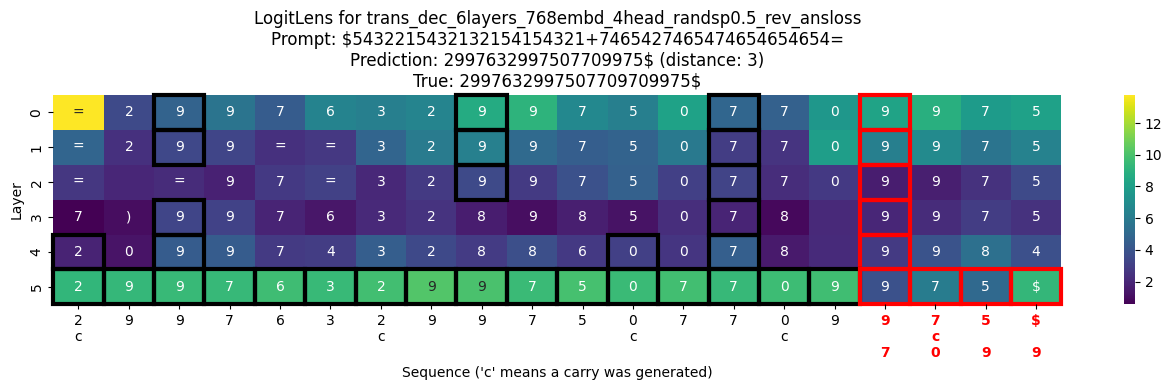

Prediction: 2997632997507709975$  (Levenshtein distance: 3)


In [41]:
a = "1234514512312345122345"
b = "4564564564745647245647"
true_ans = str(eval(f"{a}+{b}"))

if reverse_ops:
    a = a[::-1]
    b = b[::-1]

carry_str = get_carry_str(a, b, reverse=not reverse_ops)

prompt = f"${a}+{b}="

if reverse_ans:
    true_ans = true_ans[::-1]

true_ans += "$"

print(f"Prompt:      {prompt} Len: {len(a), len(b)}")
print(f"True answer: {true_ans}")
print(f"Carry:       {carry_str}")

prompt_idx = torch.tensor(tokenizer.encode(prompt, return_tensors=True)).to("mps")

_, _, pred_str = logit_lens(
    model,
    model_name,
    tokenizer,
    prompt_idx,
    true_ans=true_ans,
    max_new_tokens=20,
    carry_str=carry_str,
)
print(f"Prediction: {pred_str}  (Levenshtein distance: {distance(true_ans, pred_str)})")